# Задание

Во вложении представлен массив данных по вымышленным выданным POS-кредитам (кредитам на определенный товар). 
<br>Первая строка содержит заголовки, далее идут данные, разделитель точка с запятой. Последний столбец отвечает за факт дефолта по займу.
<br>Необходимо:
<br>•	На основании аналитического исследования выделить интересные сегменты/зависимости. 
<br>•	Создать математическую модель, способную снизить дефолт (математическая модель может включать в себя как модель классификации, так и описывать область применения модели).
<br>•	Создать отчет по модели (структура отчета на усмотрение). 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
import time

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import auc, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Data.txt', sep=';', encoding='cp1251')

In [4]:
df.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,Мужской,Среднее специальное,Мобильные телефоны,Детей нет,Другие регионы,21000,Другое,МТС,Не клиент банка,Нет дефолта
1,1,19000,6,20,Мужской,Среднее специальное,Бытовая техника,Дети есть,Другие регионы,17000,Другое,Теле2,Клиент банка,Нет дефолта
2,1,29000,12,23,Женский,Среднее специальное,Бытовая техника,Детей нет,Другие регионы,31000,Другое,Билайн,Не клиент банка,Нет дефолта
3,1,10000,12,30,Мужской,Среднее специальное,Мобильные телефоны,Дети есть,Другие регионы,31000,Никогда не был(а) женат/замужем,Теле2,Клиент банка,Нет дефолта
4,1,14500,12,25,Женский,Высшее,Мобильные телефоны,Детей нет,Другие регионы,26000,Женат/замужем,МТС,Клиент банка,Нет дефолта


In [5]:
df.shape

(1723, 14)

# Подготовка данных

In [6]:
# Переведем все категорийные признаки в цифровые с соответствующим кодированием

In [7]:
df_cat = df.copy()

In [8]:
# Признак Пол клиента

df_cat['Пол клиента'] = df_cat['Пол клиента'].apply(lambda x: 1 if x == 'Мужской' else 0)

In [9]:
# Признак Образование клиента

grd_dict = {'Неоконченное среднее':1, 
 'Среднее':2, 
 'Среднее специальное':3, 
 'Неоконченное высшее':4, 
 'Высшее':5, 
 'Несколько высших или более высокая ступень образования':6}

df_cat['Образование клиента'] = list(map(lambda x: grd_dict[x], df_cat['Образование клиента']))

In [10]:
# Признак Тип товара

label_encoder = LabelEncoder()
label_encoder.fit_transform(df[df.columns[6]])

df_cat['Тип товара'] = label_encoder.fit_transform(df[df.columns[6]])

In [11]:
# Признак Наличие детей у клиента

df_cat['Наличие детей у клиента'] = df_cat['Наличие детей у клиента'].apply(lambda x: 1 if x == 'Дети есть' else 0)

In [12]:
# Признак Регион выдачи кредита

dict_reg = {'Другие регионы':0, 
            'Санкт-Петербург или ЛО':1,
            'Москва или МО':2}

df_cat['Регион выдачи кредита'] = list(map(lambda x: dict_reg[x], df_cat['Регион выдачи кредита']))

In [13]:
# Признак Семейное положение

dict_faml = {'Никогда не был(а) женат/замужем':0, 
             'Другое':1,              
             'Женат/замужем':2}

df_cat['Семейное положение'] = list(map(lambda x: dict_faml[x], df_cat['Семейное положение']))

In [14]:
# Признак Оператор связи

dict_mob = {'МТС':5, 
            'Мегафон':4, 
            'Билайн':3, 
            'Теле2':2, 
            'Другой':1}

df_cat['Оператор связи'] = list(map(lambda x: dict_mob[x], df_cat['Оператор связи']))

In [15]:
# Признак Является ли клиентом банка

df_cat['Является ли клиентом банка'] = df_cat['Является ли клиентом банка'].apply(lambda x: 1 if x == 'Клиент банка' else 0)

In [16]:
# Признак Флаг дефолта по кредиту

df_cat['Флаг дефолта по кредиту'] = df_cat['Флаг дефолта по кредиту'].apply(lambda x: 1 if x == 'Дефолт' else 0)

In [17]:
# Теперь в данных все признаки подготовлены для визуализации и использовании в моделях предиктивных алгоритмов

In [18]:
df_cat.head()

,Месяц выдачи кредита,Сумма кредита,Срок кредита,Возраст клиента,Пол клиента,Образование клиента,Тип товара,Наличие детей у клиента,Регион выдачи кредита,Доход клиента,Семейное положение,Оператор связи,Является ли клиентом банка,Флаг дефолта по кредиту
0,1,7000,12,39,1,3,8,0,0,21000,1,5,0,0
1,1,19000,6,20,1,3,2,1,0,17000,1,2,1,0
2,1,29000,12,23,0,3,2,0,0,31000,1,3,0,0
3,1,10000,12,30,1,3,8,1,0,31000,0,2,1,0
4,1,14500,12,25,0,5,8,0,0,26000,2,5,1,0


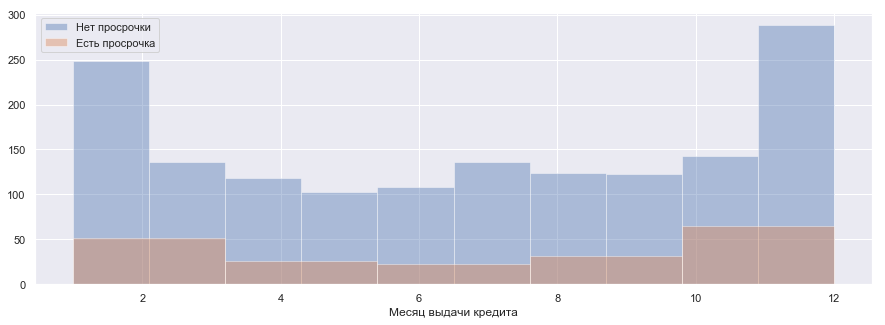

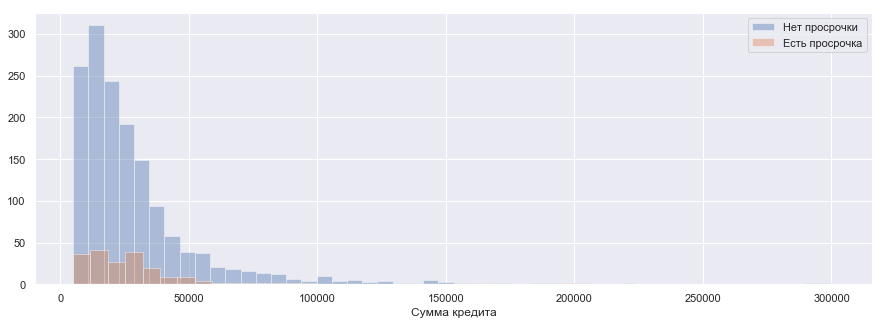

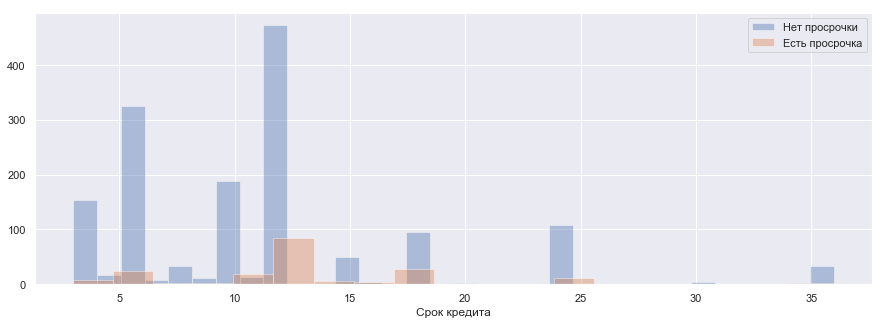

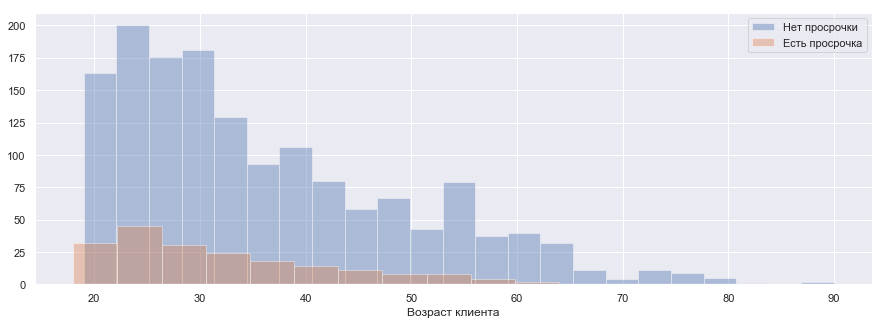

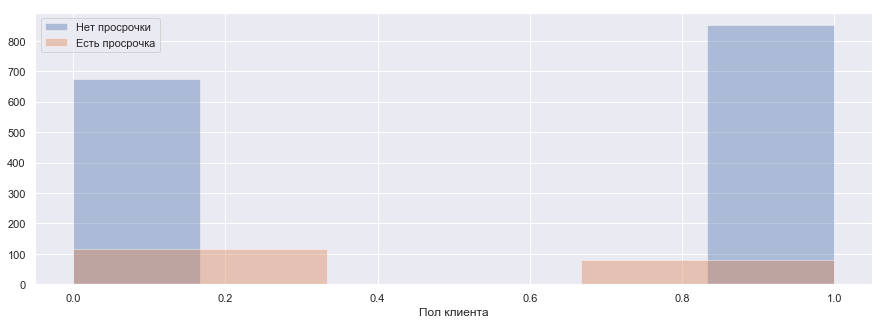

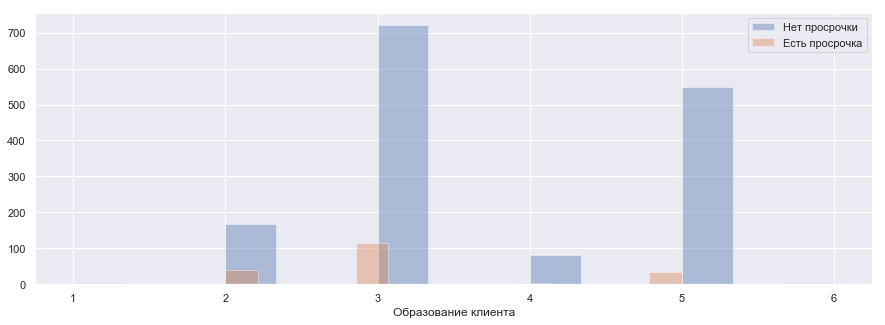

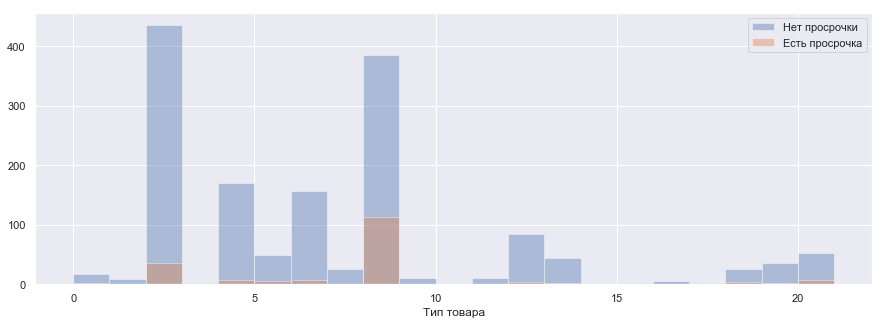

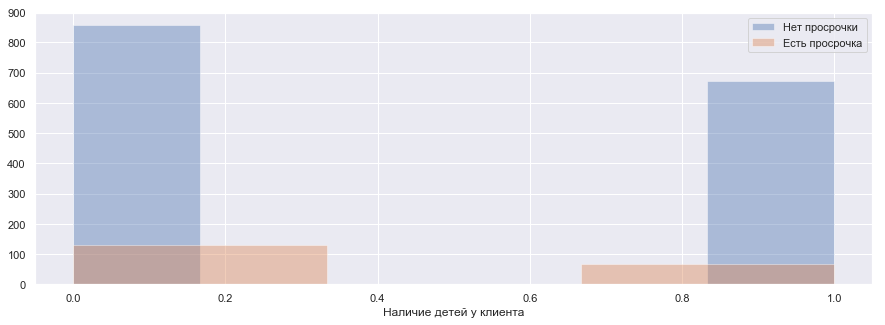

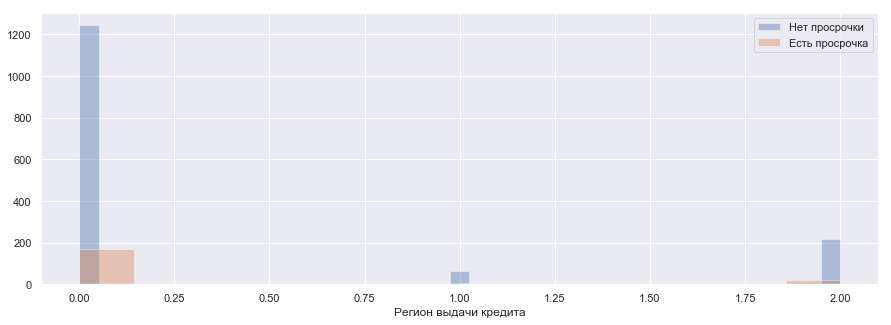

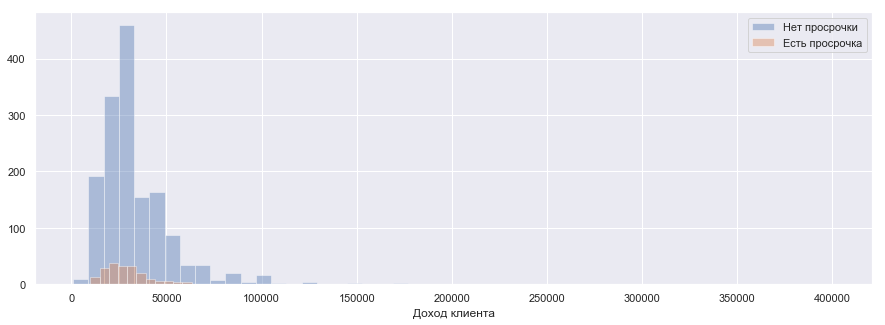

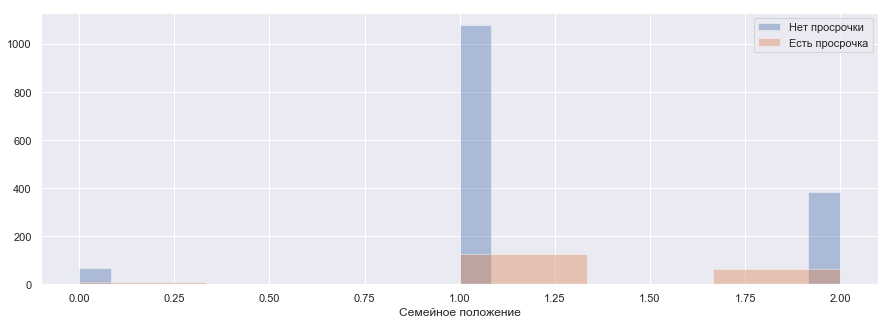

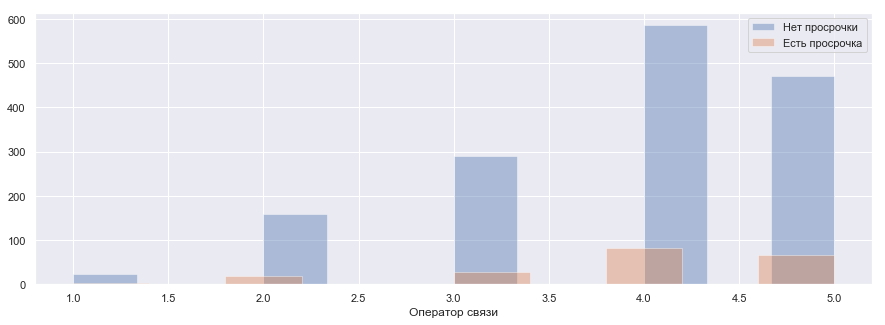

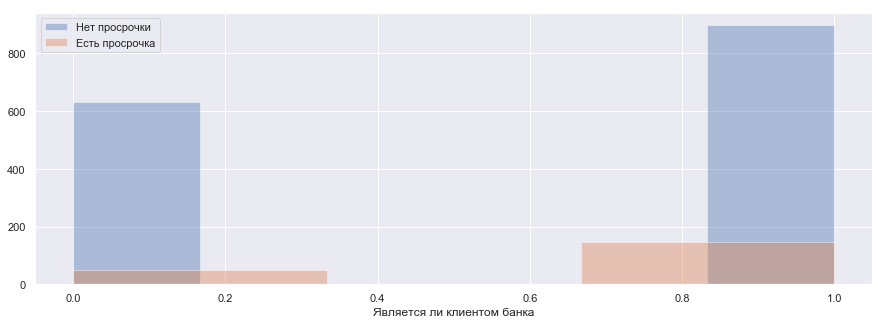

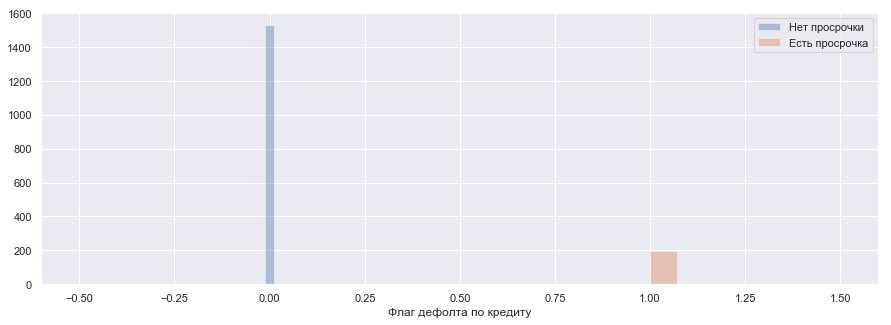

In [19]:
# Посмотрим на распределение значений каждого из признаков

for item in df.columns:
    plt.figure(figsize=[15,5])
    sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 0][item], kde=False, label='Нет просрочки')
    sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 1][item], kde=False, label='Есть просрочка')
    plt.legend()

In [20]:
#  Оценим корреляцию признаков между собой и особенно с целевым признаком - дефолт по кредиту

In [21]:
df_cat_corr = df_cat.corr()

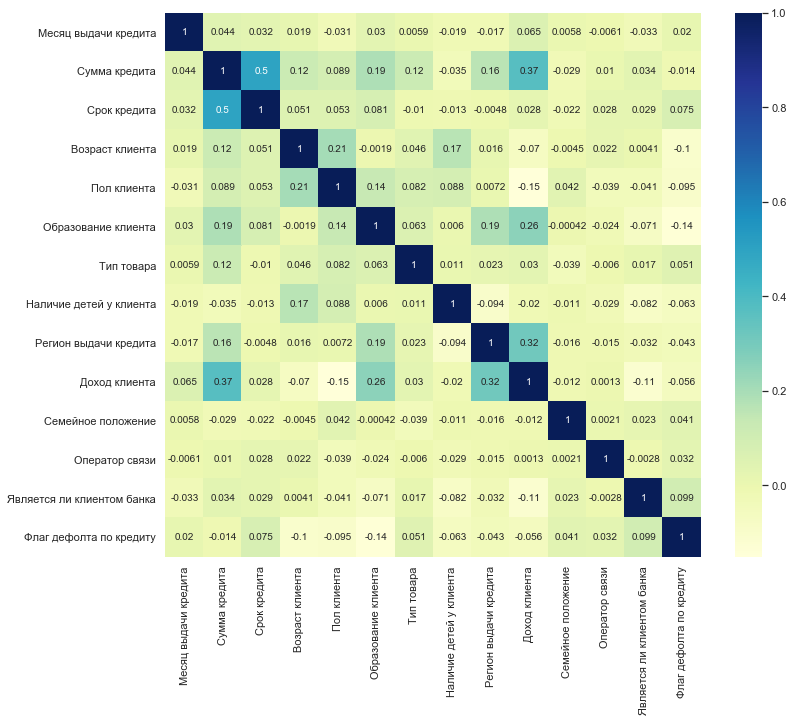

In [22]:
plt.figure(figsize=[12,10])
sns.heatmap(df_cat_corr, annot=True, cmap='YlGnBu')

Существенных зависимостей между целевым и остальными признаками не выявлено.

Далее более детально посмотрим на визуальное представление различных зависимостей признаков друг от друга в контексте дефолта по кредиту

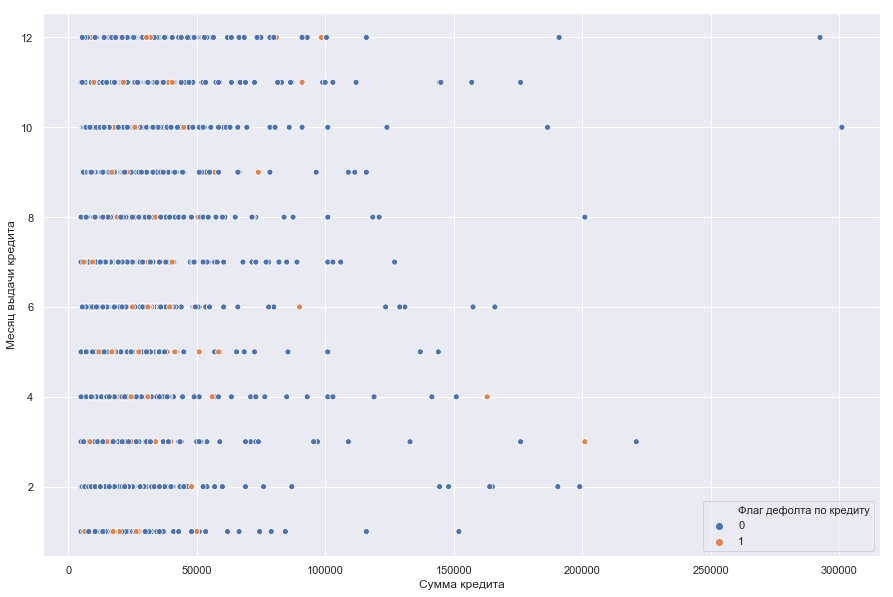

In [23]:
plt.figure(figsize=[15,10])
sns.scatterplot(df_cat['Сумма кредита'], df_cat['Месяц выдачи кредита'], hue=df_cat['Флаг дефолта по кредиту'])

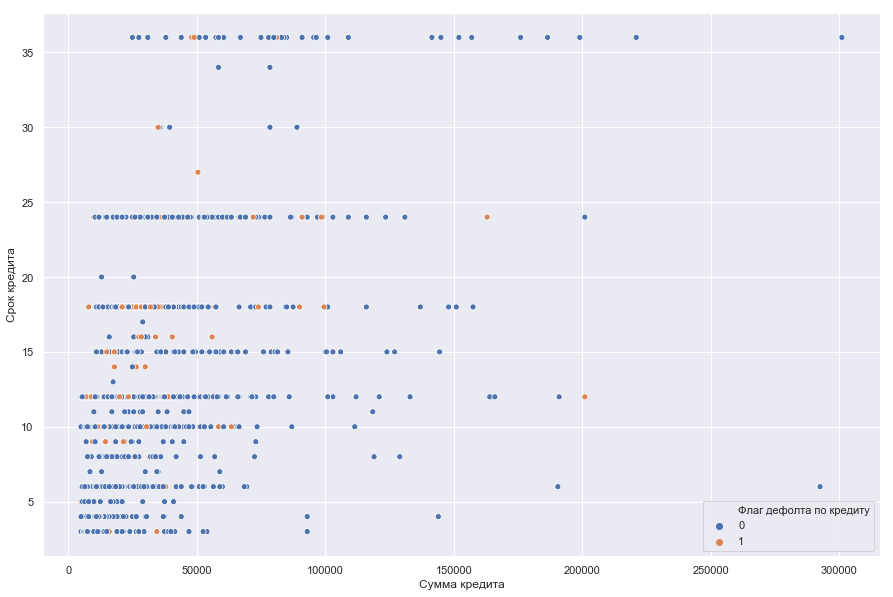

In [24]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='Сумма кредита', y='Срок кредита', data=df_cat, hue='Флаг дефолта по кредиту')

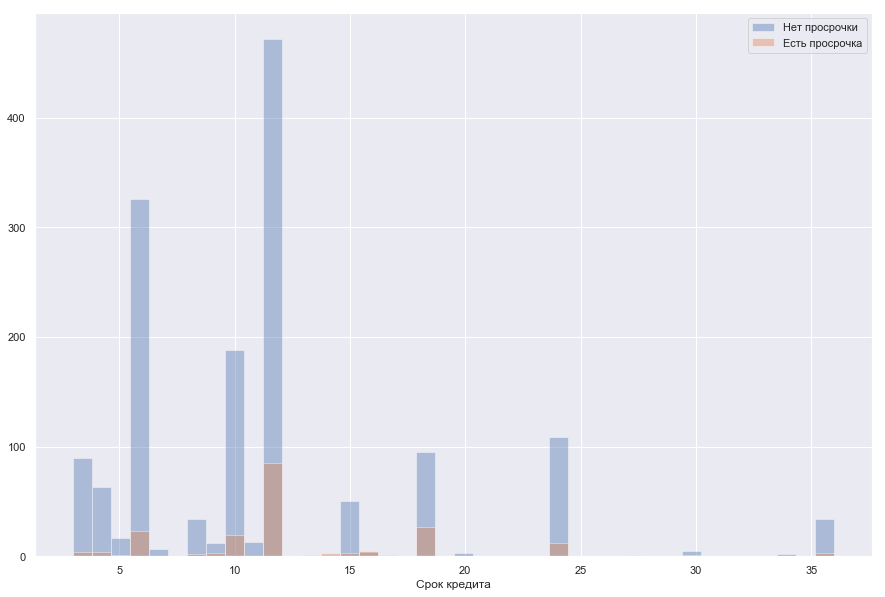

In [25]:
plt.figure(figsize=[15,10])
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 0]['Срок кредита'], kde=False, label='Нет просрочки', bins=40)
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 1]['Срок кредита'], kde=False, label='Есть просрочка', bins=40)
plt.legend()

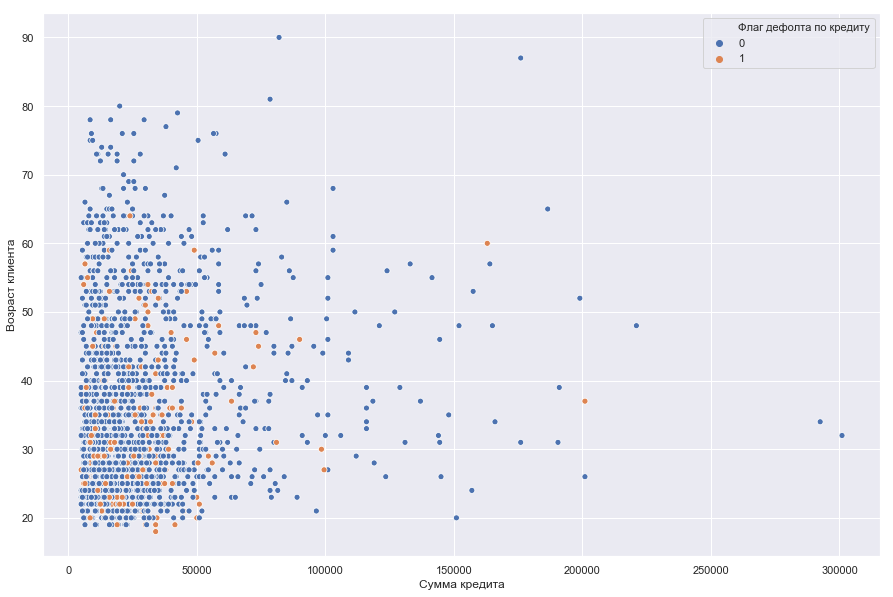

In [26]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='Сумма кредита', y='Возраст клиента', data=df_cat, hue='Флаг дефолта по кредиту')

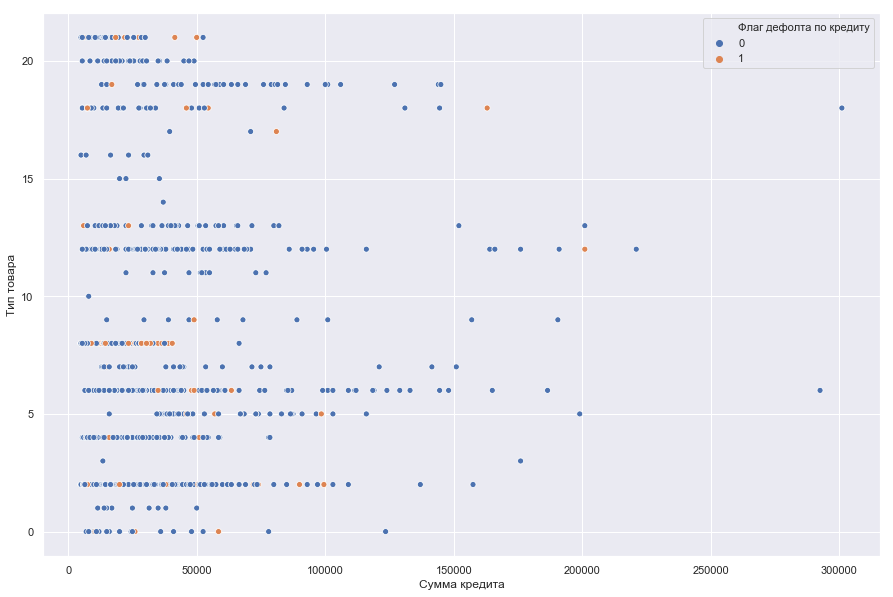

In [27]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='Сумма кредита', y='Тип товара', data=df_cat, hue='Флаг дефолта по кредиту')

In [28]:
# Можно заметить, что для некоторых товаров количество дефолтов значительно ниже, чем для других, а так же 
# есть категория в которой сосредоточено наибольшее количество дефолтов

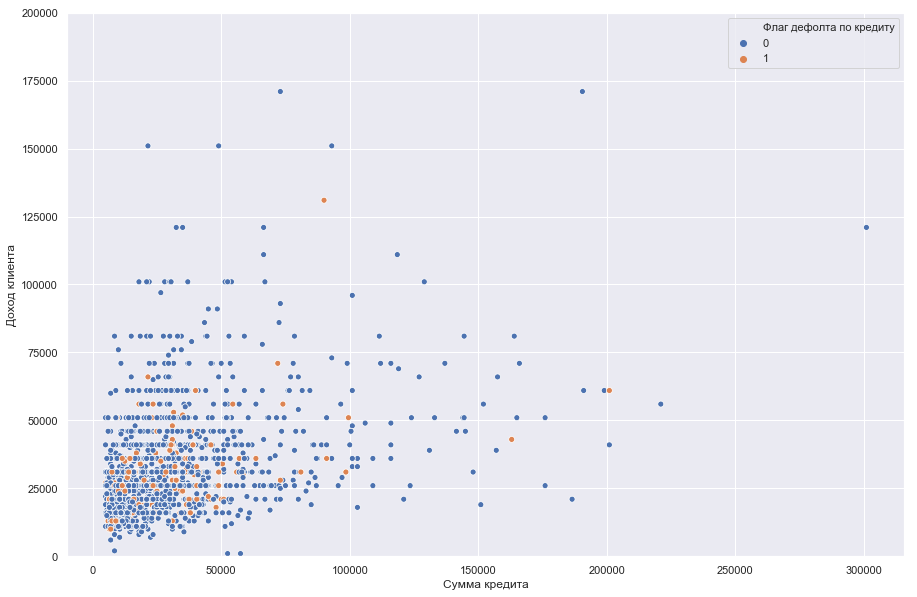

In [29]:
plt.figure(figsize=[15,10])
plt.ylim(0,200000)
sns.scatterplot(x='Сумма кредита', y='Доход клиента', data=df_cat, hue='Флаг дефолта по кредиту')

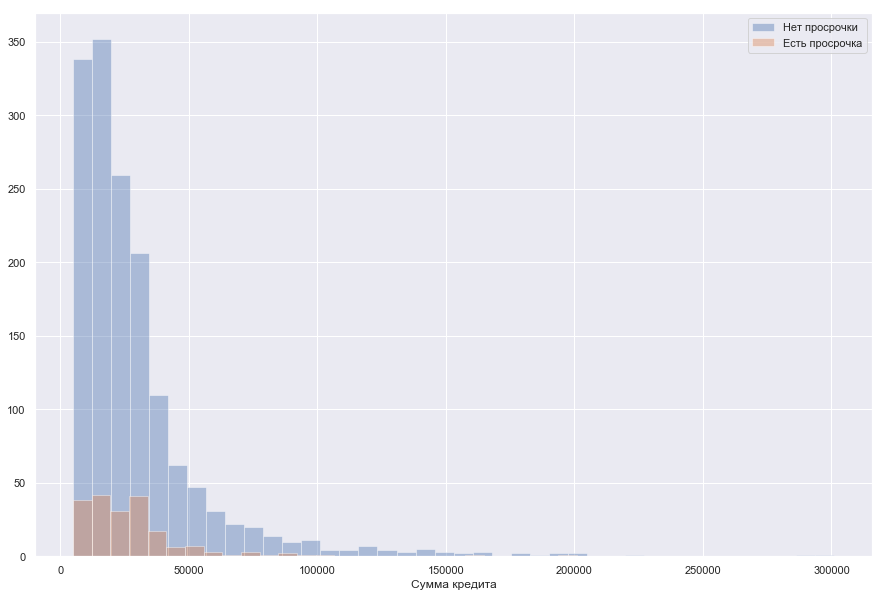

In [30]:
plt.figure(figsize=[15,10])
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 0]['Сумма кредита'], kde=False, label='Нет просрочки', bins=40)
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 1]['Сумма кредита'], kde=False, label='Есть просрочка', bins=27)
plt.legend()

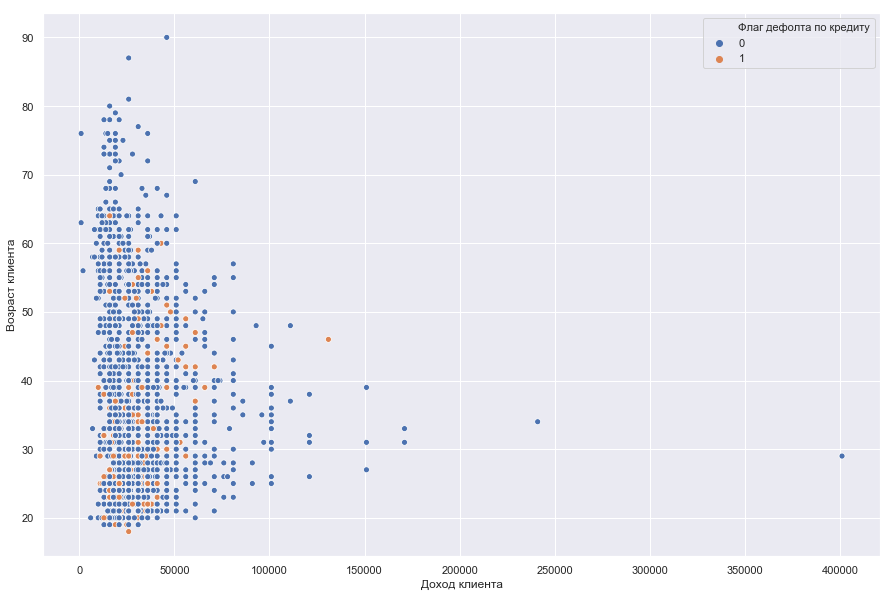

In [31]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='Доход клиента', y='Возраст клиента', data=df_cat, hue='Флаг дефолта по кредиту')

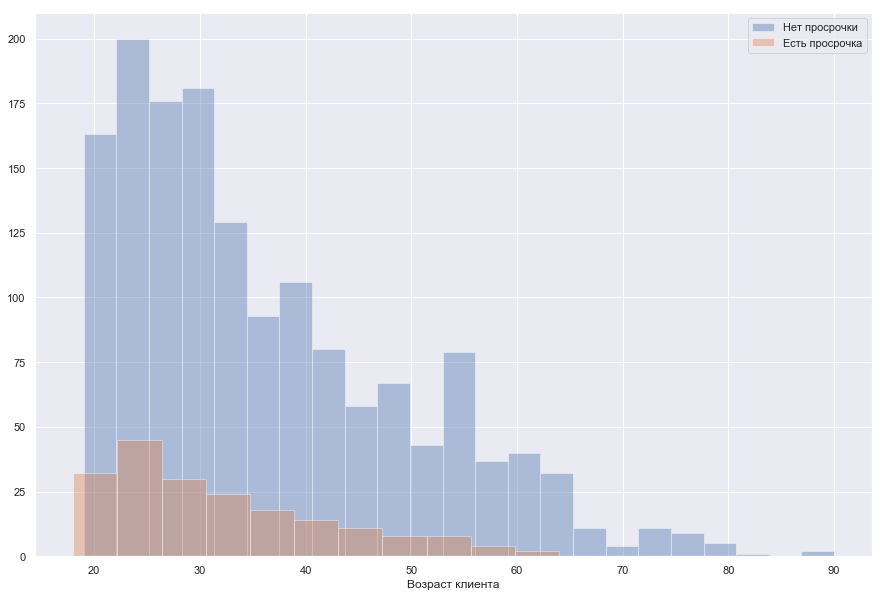

In [32]:
plt.figure(figsize=[15,10])
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 0]['Возраст клиента'], kde=False, label='Нет просрочки')
sns.distplot(df_cat[df_cat['Флаг дефолта по кредиту'] == 1]['Возраст клиента'], kde=False, label='Есть просрочка')
plt.legend()

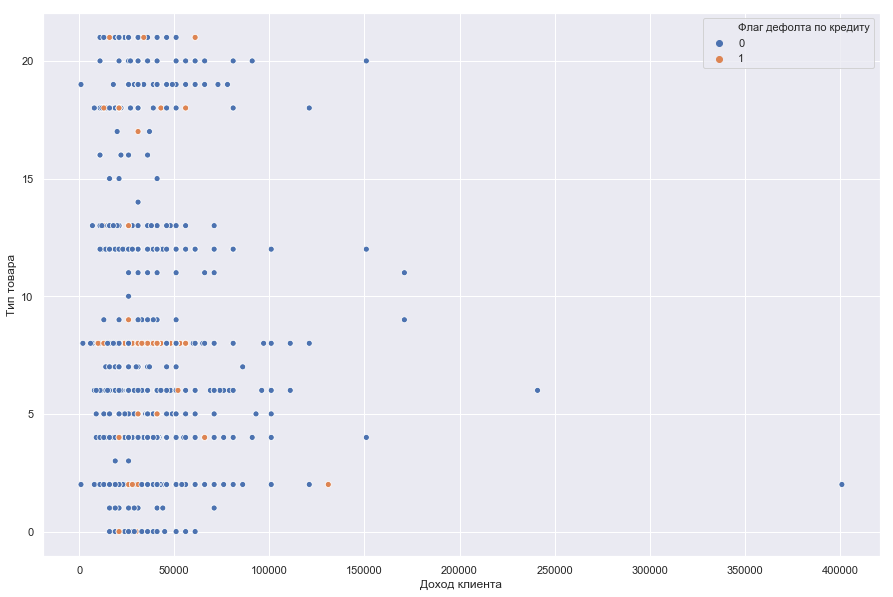

In [33]:
plt.figure(figsize=[15,10])
sns.scatterplot(x='Доход клиента', y='Тип товара', data=df_cat, hue='Флаг дефолта по кредиту')

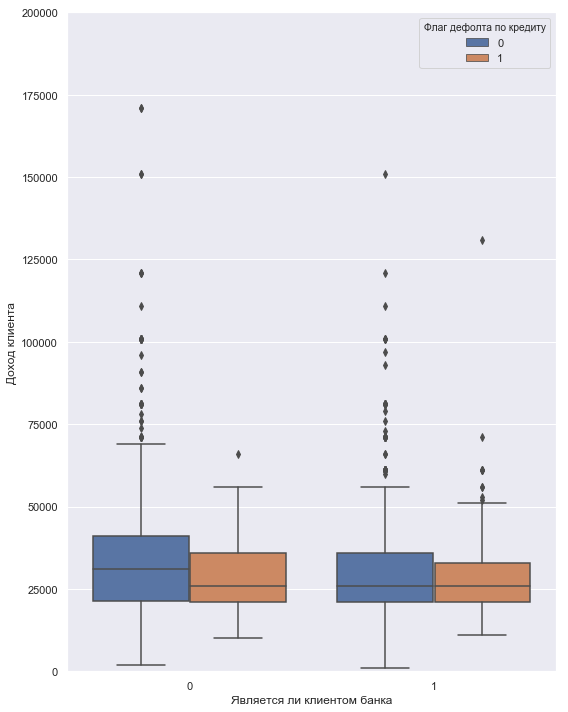

In [34]:
plt.figure(figsize=[8,10])
plt.ylim(0,200000)
sns.boxplot(y='Доход клиента', x='Является ли клиентом банка', data=df_cat, hue='Флаг дефолта по кредиту')
plt.tight_layout()

Как можно увидеть на графике BoxPlot, разброс значений доходов клиентов, допустивших дефолт по кредиту, несколько меньше, чем для клиентов не допустивших дефолт

# Построение математической модели

In [35]:
df_cat_x = df_cat.drop('Флаг дефолта по кредиту', axis=1)
df_cat_y = df_cat['Флаг дефолта по кредиту']

In [36]:
## Первичная оценка наиболее популярных предиктивных моделей со стандартными гиперпараметрами

In [37]:
X = df_cat_x
y = df_cat_y

In [38]:
# Logging for Visual Comparison
log_cols=["Classifier", "roc_auc_score", "Time"]
log = pd.DataFrame(columns=log_cols)

In [39]:
classifiers = [
    GaussianNB(),
    BaggingClassifier(GaussianNB(),n_jobs=-1),
    LinearDiscriminantAnalysis(),
    BaggingClassifier(LinearDiscriminantAnalysis(),n_jobs=-1),
    QuadraticDiscriminantAnalysis(),
    BaggingClassifier(QuadraticDiscriminantAnalysis(),n_jobs=-1),
    SGDClassifier(loss='log',n_jobs=-1),
    BaggingClassifier(SGDClassifier(loss='log',n_jobs=-1),n_jobs=-1),
    lgb.LGBMClassifier(),
    BaggingClassifier(lgb.LGBMClassifier(),n_jobs=-1),
    xgb.XGBClassifier(n_jobs=8),
    BaggingClassifier(xgb.XGBClassifier(n_jobs=8),n_jobs=-1),
    DecisionTreeClassifier(),
    BaggingClassifier(n_jobs=-1),
    RandomForestClassifier(n_jobs=-1),
    BaggingClassifier(RandomForestClassifier(),n_jobs=-1),
    AdaBoostClassifier(),
    BaggingClassifier(AdaBoostClassifier(),n_jobs=-1),
    GradientBoostingClassifier(),
    BaggingClassifier(GradientBoostingClassifier(),n_jobs=-1),
    SVC(kernel="rbf", C=0.025, probability=True),
    BaggingClassifier(SVC(kernel="rbf", C=0.025),n_jobs=-1),
    KNeighborsClassifier(n_neighbors=2,n_jobs=-1),
    BaggingClassifier(KNeighborsClassifier(n_neighbors=2,n_jobs=-1),n_jobs=-1),
]

In [40]:
%%time
skf = StratifiedKFold(n_splits=10, random_state=101, shuffle=True)
iteration = 1
for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for clf in classifiers:
        start_time = time.time()
        clf.fit(X_train, y_train)
        if clf.__class__.__name__ == 'BaggingClassifier':
            name = str((clf.base_estimator_)).split('(')[0] + '_' + clf.__class__.__name__
        else:
            name = clf.__class__.__name__

        print("="*30)
        print(name)

        print('****Results****')
        train_predictions = clf.predict_proba(X_test)[:,1]
        end_time = time.time() - start_time
        roc_auc = roc_auc_score(y_test, train_predictions)
        print("ROC AUC: {:.7%}".format(roc_auc))
        print('Time : {:.2f}'.format(end_time), 'second')
        print('Current iteration KFold: ',iteration)

        log_entry = pd.DataFrame([[name, roc_auc, end_time]], columns=log_cols)
        log = log.append(log_entry)
        
        log.to_csv('output/001_BCS_02.csv', sep=';', index=None)

    print("="*30)
    iteration += 1
    
log.groupby('Classifier').describe().sort_values(by=('roc_auc_score','mean'),ascending=False)[['roc_auc_score','Time']]


GaussianNB
****Results****
ROC AUC: 65.5228758%
Time : 0.00 second
Current iteration KFold:  1
GaussianNB_BaggingClassifier
****Results****
ROC AUC: 64.3464052%
Time : 2.13 second
Current iteration KFold:  1
LinearDiscriminantAnalysis
****Results****
ROC AUC: 68.9215686%
Time : 0.01 second
Current iteration KFold:  1
LinearDiscriminantAnalysis_BaggingClassifier
****Results****
ROC AUC: 69.4117647%
Time : 0.09 second
Current iteration KFold:  1
QuadraticDiscriminantAnalysis
****Results****
ROC AUC: 66.0784314%
Time : 0.00 second
Current iteration KFold:  1
QuadraticDiscriminantAnalysis_BaggingClassifier
****Results****
ROC AUC: 67.0261438%
Time : 0.03 second
Current iteration KFold:  1
SGDClassifier
****Results****
ROC AUC: 50.0000000%
Time : 0.00 second
Current iteration KFold:  1
SGDClassifier_BaggingClassifier
****Results****
ROC AUC: 47.5490196%
Time : 0.04 second
Current iteration KFold:  1
LGBMClassifier
****Results****
ROC AUC: 68.1045752%
Time : 0.13 second
Current iteration KFo

LGBMClassifier_BaggingClassifier
****Results****
ROC AUC: 73.2026144%
Time : 0.39 second
Current iteration KFold:  3
XGBClassifier
****Results****
ROC AUC: 72.1568627%
Time : 0.11 second
Current iteration KFold:  3
XGBClassifier_BaggingClassifier
****Results****
ROC AUC: 71.8627451%
Time : 0.43 second
Current iteration KFold:  3
DecisionTreeClassifier
****Results****
ROC AUC: 51.6176471%
Time : 0.01 second
Current iteration KFold:  3
DecisionTreeClassifier_BaggingClassifier
****Results****
ROC AUC: 72.8921569%
Time : 0.04 second
Current iteration KFold:  3
RandomForestClassifier
****Results****
ROC AUC: 63.1862745%
Time : 0.22 second
Current iteration KFold:  3
RandomForestClassifier_BaggingClassifier
****Results****
ROC AUC: 72.2058824%
Time : 0.10 second
Current iteration KFold:  3
AdaBoostClassifier
****Results****
ROC AUC: 74.4771242%
Time : 0.09 second
Current iteration KFold:  3
AdaBoostClassifier_BaggingClassifier
****Results****
ROC AUC: 75.8496732%
Time : 0.37 second
Current i

GradientBoostingClassifier
****Results****
ROC AUC: 75.2287582%
Time : 0.11 second
Current iteration KFold:  5
GradientBoostingClassifier_BaggingClassifier
****Results****
ROC AUC: 77.7124183%
Time : 0.33 second
Current iteration KFold:  5
SVC
****Results****
ROC AUC: 49.3464052%
Time : 0.87 second
Current iteration KFold:  5
SVC_BaggingClassifier
****Results****
ROC AUC: 50.0000000%
Time : 0.22 second
Current iteration KFold:  5
KNeighborsClassifier
****Results****
ROC AUC: 53.3496732%
Time : 0.11 second
Current iteration KFold:  5
KNeighborsClassifier_BaggingClassifier
****Results****
ROC AUC: 55.5065359%
Time : 0.26 second
Current iteration KFold:  5
GaussianNB
****Results****
ROC AUC: 70.4575163%
Time : 0.01 second
Current iteration KFold:  6
GaussianNB_BaggingClassifier
****Results****
ROC AUC: 69.9346405%
Time : 0.03 second
Current iteration KFold:  6
LinearDiscriminantAnalysis
****Results****
ROC AUC: 76.5359477%
Time : 0.01 second
Current iteration KFold:  6
LinearDiscriminantA

SGDClassifier
****Results****
ROC AUC: 50.0000000%
Time : 0.00 second
Current iteration KFold:  8
SGDClassifier_BaggingClassifier
****Results****
ROC AUC: 52.9085873%
Time : 0.04 second
Current iteration KFold:  8
LGBMClassifier
****Results****
ROC AUC: 67.1745152%
Time : 0.11 second
Current iteration KFold:  8
LGBMClassifier_BaggingClassifier
****Results****
ROC AUC: 71.9529086%
Time : 0.40 second
Current iteration KFold:  8
XGBClassifier
****Results****
ROC AUC: 77.6315789%
Time : 0.11 second
Current iteration KFold:  8
XGBClassifier_BaggingClassifier
****Results****
ROC AUC: 74.2728532%
Time : 0.42 second
Current iteration KFold:  8
DecisionTreeClassifier
****Results****
ROC AUC: 56.9078947%
Time : 0.01 second
Current iteration KFold:  8
DecisionTreeClassifier_BaggingClassifier
****Results****
ROC AUC: 68.8019391%
Time : 0.03 second
Current iteration KFold:  8
RandomForestClassifier
****Results****
ROC AUC: 71.1218837%
Time : 0.22 second
Current iteration KFold:  8
RandomForestClass

AdaBoostClassifier
****Results****
ROC AUC: 65.0277008%
Time : 0.08 second
Current iteration KFold:  10
AdaBoostClassifier_BaggingClassifier
****Results****
ROC AUC: 63.4002770%
Time : 0.35 second
Current iteration KFold:  10
GradientBoostingClassifier
****Results****
ROC AUC: 69.0096953%
Time : 0.10 second
Current iteration KFold:  10
GradientBoostingClassifier_BaggingClassifier
****Results****
ROC AUC: 72.6454294%
Time : 0.34 second
Current iteration KFold:  10
SVC
****Results****
ROC AUC: 46.0180055%
Time : 0.83 second
Current iteration KFold:  10
SVC_BaggingClassifier
****Results****
ROC AUC: 50.0000000%
Time : 0.23 second
Current iteration KFold:  10
KNeighborsClassifier
****Results****
ROC AUC: 47.9224377%
Time : 0.11 second
Current iteration KFold:  10
KNeighborsClassifier_BaggingClassifier
****Results****
ROC AUC: 49.9826870%
Time : 0.28 second
Current iteration KFold:  10
Wall time: 44.3 s


In [41]:
# Отсортируем модели со страндартными гиперпараметрами по итоговому усредненному по 10 фолдам скору

In [42]:
log.groupby('Classifier').describe(percentiles=[]).sort_values(by=('roc_auc_score','mean'),ascending=False)[['roc_auc_score','Time']]

roc_auc_score            \
                                                        count      mean   
Classifier                                                                
GradientBoostingClassifier_BaggingClassifier             10.0  0.740410   
XGBClassifier                                            10.0  0.737865   
XGBClassifier_BaggingClassifier                          10.0  0.735523   
RandomForestClassifier_BaggingClassifier                 10.0  0.733576   
GradientBoostingClassifier                               10.0  0.728431   
AdaBoostClassifier                                       10.0  0.726723   
LGBMClassifier_BaggingClassifier                         10.0  0.716325   
DecisionTreeClassifier_BaggingClassifier                 10.0  0.711385   
AdaBoostClassifier_BaggingClassifier                     10.0  0.707700   
LGBMClassifier                                           10.0  0.706485   
LinearDiscriminantAnalysis                               10.0  0.694269   
LinearDiscriminantAnalysis_BaggingClassifier             10.0  0.692554   
GaussianNB                                               10.0  0.678183   
GaussianNB_BaggingClassifier                             10.0  0.674417   
RandomForestClassifier                                   10.0  0.674210   
QuadraticDiscriminantAnalysis                            10.0  0.673809   
QuadraticDiscriminantAnalysis_BaggingClassifier          10.0  0.671903   
DecisionTreeClassifier                                   10.0  0.561065   
SVC_BaggingClassifier                                    10.0  0.500000   
SGDClassifier                                            10.0  0.496487   
SGDClassifier_BaggingClassifier                          10.0  0.492404   
SVC                                                      10.0  0.487873   
KNeighborsClassifier                                     10.0  0.483818   
KNeighborsClassifier_BaggingClassifier                   10.0  0.483584   

                                                                               \
                                                      std       min       50%   
Classifier                                                                      
GradientBoostingClassifier_BaggingClassifier     0.045047  0.648199  0.752367   
XGBClassifier                                    0.056079  0.628809  0.754739   
XGBClassifier_BaggingClassifier                  0.047060  0.647507  0.737479   
RandomForestClassifier_BaggingClassifier         0.047645  0.675490  0.734232   
GradientBoostingClassifier                       0.048305  0.629848  0.741176   
AdaBoostClassifier                               0.054980  0.620499  0.746078   
LGBMClassifier_BaggingClassifier                 0.046843  0.635388  0.722472   
DecisionTreeClassifier_BaggingClassifier         0.062784  0.643301  0.696216   
AdaBoostClassifier_BaggingClassifier             0.073641  0.546053  0.724837   
LGBMClassifier                                   0.043836  0.634003  0.700838   
LinearDiscriminantAnalysis                       0.059933  0.594529  0.693464   
LinearDiscriminantAnalysis_BaggingClassifier     0.060322  0.595222  0.694118   
GaussianNB                                       0.103478  0.495845  0.679902   
GaussianNB_BaggingClassifier                     0.099942  0.500000  0.669764   
RandomForestClassifier                           0.072082  0.521078  0.687759   
QuadraticDiscriminantAnalysis                    0.077980  0.555748  0.666667   
QuadraticDiscriminantAnalysis_BaggingClassifier  0.087282  0.520083  0.674346   
DecisionTreeClassifier                           0.039378  0.486765  0.567563   
SVC_BaggingClassifier                            0.000000  0.500000  0.500000   
SGDClassifier                                    0.007423  0.481373  0.500000   
SGDClassifier_BaggingClassifier                  0.060473  0.410561  0.476797   
SVC                                              0.082603  0.351454  0.476822 

## Оценка предиктивных моделей на основе LightGBM

In [43]:
model = lgb.LGBMClassifier(num_leaves=31, 
                           max_depth=3, 
                           learning_rate=0.01, 
                           n_estimators=100, 
                           objective='binary', 
                           random_state=101, 
                           n_jobs=-1)

In [44]:
%%time
cvs = cross_val_score(model, df_cat_x, df_cat_y, cv=10, n_jobs=-1, scoring='roc_auc')
print(cvs, '\n', 'MEAN = ',cvs.mean())

[ 0.68970588  0.84264706  0.6880719   0.67581699  0.7874183   0.82941176
  0.74853801  0.7058518   0.70256233  0.70550554] 
 MEAN =  0.737552957471
Wall time: 140 ms


In [45]:
## Бэггинг модели для улучшения скора модели

In [46]:
model_inner = lgb.LGBMClassifier(num_leaves=31, 
                           max_depth=3, 
                           learning_rate=0.01, 
                           n_estimators=100, 
                           objective='binary', 
                           random_state=101, 
                           n_jobs=-1)
model = BaggingClassifier(model_inner, n_estimators=500, random_state=101, n_jobs=-1)

In [47]:
%%time
cvs = cross_val_score(model, df_cat_x, df_cat_y, cv=10, n_jobs=-1, scoring='roc_auc')
print(cvs, '\n', 'MEAN = ',cvs.mean())

[ 0.70784314  0.8379085   0.68169935  0.71568627  0.78333333  0.81732026
  0.74372205  0.71745152  0.73649584  0.7132964 ] 
 MEAN =  0.745475666721
Wall time: 30.4 s


## Оценка предиктивных моделей на основе  XGBoost

In [48]:
model_inner = xgb.XGBClassifier(
                max_depth=3,
                learning_rate=0.01,
                n_estimators=100,
                silent=True,
                objective='binary:logistic', 
                booster='gbtree', 
                n_jobs=-1,
                nthread=None,
                gamma=0,
                min_child_weight=1,
                max_delta_step=0,
                subsample=1,
                colsample_bytree=1,
                colsample_bylevel=1,
                reg_alpha=0,
                reg_lambda=1,
                scale_pos_weight=1,
                base_score=0.5,
                random_state=101,
                seed=None,
                missing=None
                )

model = BaggingClassifier(model_inner, n_estimators=500, random_state=101, n_jobs=-1)

In [49]:
%%time
cvs = cross_val_score(model, df_cat_x, df_cat_y, cv=10, n_jobs=-1, scoring='roc_auc')
print(cvs, '\n', 'MEAN = ',cvs.mean())

[ 0.69444444  0.82679739  0.70490196  0.70588235  0.78104575  0.79869281
  0.73374613  0.69944598  0.74376731  0.72645429] 
 MEAN =  0.741517842594
Wall time: 3min 58s


Лучшие модели дают точность предстказания факта дефолта по кредиту на уровне <b>74%</b>. В дальнейшем можно попытаться более точно настроить модель перебором гиперпараметров.

Такая точность модели ещё недостаточно хороша для внедрения в промышленное происзводство, возможно нам не хватает исходных данных или стоит попробовать генерацию новых фичей для улучшения качества модели. Как миминум данную модель можно использовать для регулирования лимитов выдаваемых кредитов, что в свою очередь может существенно сократить общий объем просрочки в денежном выражении.

Далее посмотрим на признаки, которые существенее всего влияют на модель при расчете целевой функции.

In [50]:
### Оценка важности каждого признака для предиктивной модели LightGBM

In [51]:
model = lgb.LGBMClassifier(num_leaves=31, 
                           max_depth=3, 
                           learning_rate=0.01, 
                           n_estimators=100, 
                           objective='binary', 
                           random_state=101, 
                           n_jobs=-1)

In [52]:
%%time
model.fit(X=df_cat_x, y=df_cat_y)

Wall time: 72.2 ms


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.01, max_depth=3,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=101, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [53]:
model.feature_importances_

array([ 13,  63, 144,  87,  20,  65, 168,   0,  20,   9,  28,  21,  62])

In [54]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,df_cat_x.columns)), columns=['Value', 'Feature'])

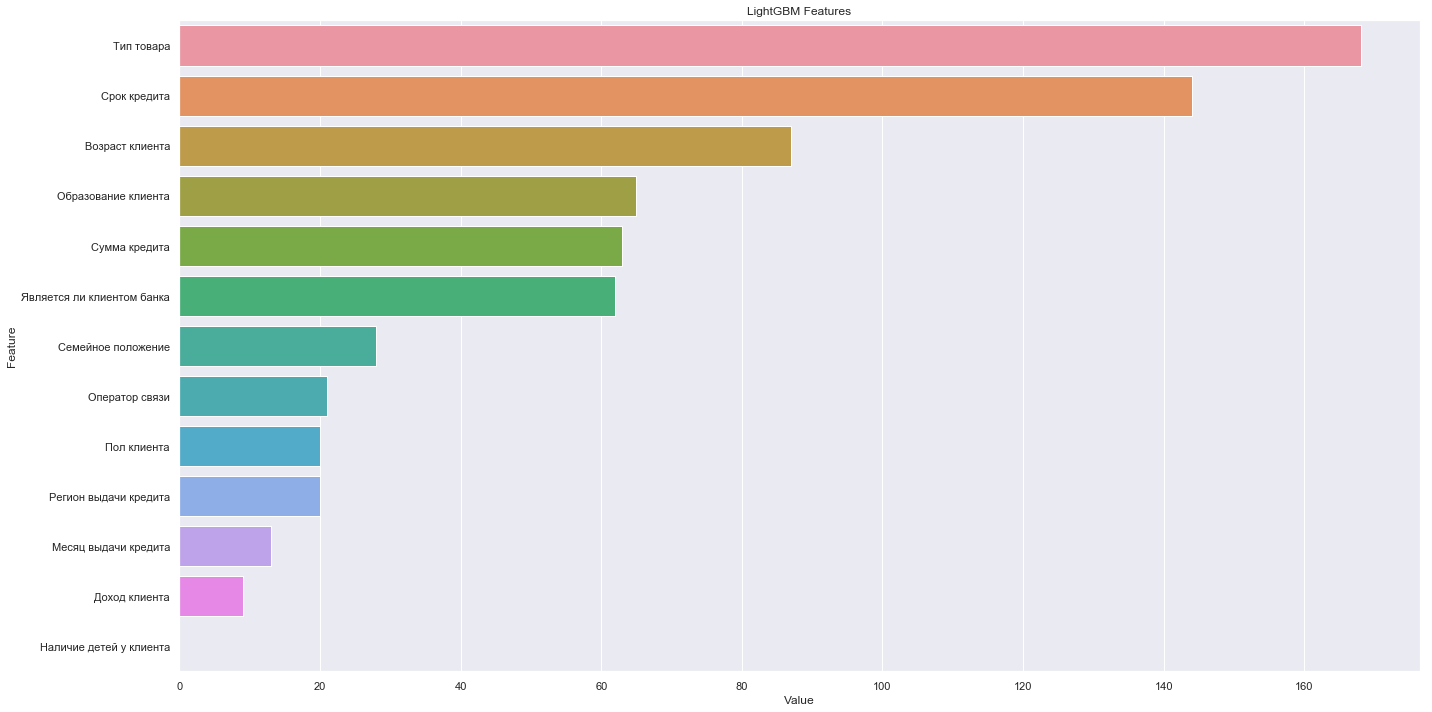

In [55]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()

Наиболее значимым признаком для модели на основе LightGBM предсказывающей дефолт по кредиту это Тип товара, и далее по нисходящей в порядке важности на графике выше

Посмотрим подробнее на дефолты по кредитам в разрезе разных типов товаров.

In [56]:
df_fe_imp = pd.concat([df[df['Флаг дефолта по кредиту'] == 'Дефолт']['Тип товара'].value_counts(), 
                       df[df['Флаг дефолта по кредиту'] == 'Нет дефолта']['Тип товара'].value_counts(),
                      df[['Тип товара', 'Сумма кредита']].groupby('Тип товара').mean().sort_values('Сумма кредита', ascending=False).round()], axis=1)
df_fe_imp.columns=['Дефолт', 'Нет дефолта', 'Средняя сумма кредита']
df_fe_imp.sort_values('Дефолт', ascending=False, inplace=True)
df_fe_imp['% по группе'] = round((df_fe_imp['Дефолт'] / (df_fe_imp['Дефолт'] + df_fe_imp['Нет дефолта'])) * 100, 2)
count_deals = df_fe_imp[['Дефолт', 'Нет дефолта']].sum().sum()
df_fe_imp['% взвешенный'] = round(((df_fe_imp['Дефолт'] + df_fe_imp['Нет дефолта']) / count_deals) * 100, 2)
df_fe_imp.fillna(0, inplace=True)
df_fe_imp = df_fe_imp[['Дефолт', 'Нет дефолта', '% по группе', '% взвешенный', 'Средняя сумма кредита']]
df_fe_imp

,Дефолт,Нет дефолта,% по группе,% взвешенный,Средняя сумма кредита
Мобильные телефоны,113.0,385,22.69,28.90,18391.0
Бытовая техника,36.0,435,7.64,27.34,25623.0
"Компьютеры, комплектующие",8.0,170,4.49,10.33,22607.0
Мебель,8.0,156,4.88,9.52,40134.0
Ювелирные украшения,8.0,28,22.22,2.09,18292.0
Косметика и косметические услуги,5.0,50,9.09,3.19,60400.0
"Одежда, изделия из меха и кожи",4.0,84,4.55,5.11,48438.0
Строительные материалы и инструменты,4.0,26,13.33,1.74,47117.0
Автомобильные товары,3.0,18,14.29,1.22,30905.0
"Окна, двери",2.0,45,4.26,2.73,40181.0


Исходя из представленной таблицы выше, можно сегментировать категории товаров так, чтобы сконцентрироваться на выдаче кредитов из категорий имеющих нименьший процент дефолта по группе, но при этом остающемся значимой с точки зрения количества выдаваемых кредитов (как например Фитнес, Обучение, Мед.услуги, Туризм, Одежда, Кометика и т.д.), и наоборот сокращать количество или лимиты выдаваемых товаров из категорий имеющих наибольший процент дефолтов в группе при наибольшем количестве выдаваемых кредитов (как например Моб.телефоны, Ювелирные украшения)